<a href="https://colab.research.google.com/github/XuanLoc2578/AirPassenger_Kaggle/blob/main/Torch_AirPassenger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem: Predict the number of passenger in the near future**


In [269]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [270]:
from google.colab import files
files.upload()
!ls

Saving AirPassengers.csv to AirPassengers (7).csv
'AirPassengers (1).csv'  'AirPassengers (4).csv'  'AirPassengers (7).csv'
'AirPassengers (2).csv'  'AirPassengers (5).csv'   AirPassengers.csv
'AirPassengers (3).csv'  'AirPassengers (6).csv'   sample_data


## **Preprocessing**
⬇⬇⬇

In [271]:
df = pd.read_csv("AirPassengers.csv")
df["Month"] = pd.to_datetime(df["Month"])
t_s = df["Month"]
df = df.set_index("Month")

In [272]:
training_set = df.iloc[:, 0].values.reshape(-1, 1)

In [273]:
df.head(3)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132


In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [275]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


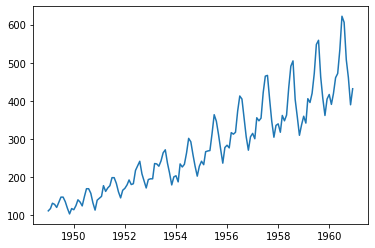

In [276]:
plt.plot(t_s, training_set)

In [277]:
sc = MinMaxScaler()
data = sc.fit_transform(training_set)

## **Create model**
⬇⬇⬇

In [299]:
def slide_window(data, seq_length):
  x = []
  y = []

  for i in range(len(data)-seq_length-1):
    tmp_x = data[i:(i+seq_length)]
    tmp_y = data[i+seq_length]
    x.append(tmp_x)
    y.append(tmp_y)

  return np.array(x), np.array(y)

In [300]:
seq_length = 5

x, y = slide_window(data, seq_length)

In [301]:
x.shape, y.shape

((138, 5, 1), (138, 1))

In [302]:
test_size = 24

X_train = torch.tensor(np.array(x[:-test_size]), dtype=torch.float32)
X_test = torch.tensor(np.array(x[-test_size:]), dtype=torch.float32)
y_train = torch.tensor(np.array(y[:-test_size]), dtype=torch.float32)
y_test = torch.tensor(np.array(y[-test_size:]), dtype=torch.float32)

In [303]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([114, 5, 1]),
 torch.Size([24, 5, 1]),
 torch.Size([114, 1]),
 torch.Size([24, 1]))

In [396]:
class GRU(nn.Module):
  def __init__(self, inp_size, hid_size, seq_len, n_layer):
    super().__init__()
    self.seq_len = seq_len
    self.hid_size = hid_size
    self.n_layer = n_layer

    self.gru = nn.GRU(inp_size, hid_size, n_layer, dropout=0.2, batch_first=True)
    self.linear = nn.Linear(hid_size*seq_len, 1)

  def forward(self, x):
    h0 = torch.zeros(self.n_layer, x.size(0), self.hid_size)
    # c0 = torch.zeros(self.n_layer, x.size(0), self.hid_size)

    # out, _ = self.lstm(x, (h0, c0))
    out, _ = self.gru(x, h0)
    out = out.reshape(out.shape[0], -1)
    return self.linear(out)

In [397]:
inp_size = 1
hid_size = 64
seq_len = seq_length
n_layer = 2

lr = 0.001
num_epoch = 2000

model = GRU(inp_size, hid_size, seq_len, n_layer)

loss = nn.MSELoss()
solver = optim.Adam(model.parameters(), lr=lr)

Epoch 0, loss 0.12935958802700043
Epoch 200, loss 0.004971793852746487
Epoch 400, loss 0.0025580129586160183
Epoch 600, loss 0.0028768840711563826
Epoch 800, loss 0.002452234271913767
Epoch 1000, loss 0.002030258299782872
Epoch 1200, loss 0.0013210756005719304
Epoch 1400, loss 0.0010646359296515584
Epoch 1600, loss 0.0008570981444790959
Epoch 1800, loss 0.0006935454439371824


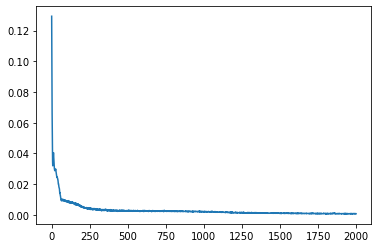

In [398]:
loss_list = []

for epoch in range(num_epoch):
  l = loss(model(X_train), y_train)

  solver.zero_grad()
  l.backward()
  loss_list.append(l)
  solver.step()

  if epoch%(num_epoch/10)==0:
    print(f"Epoch {epoch}, loss {l}")


plt.plot(loss_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


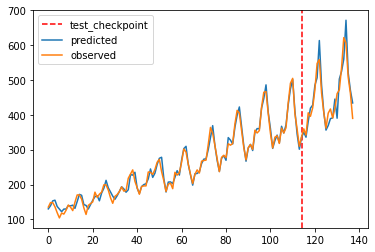

In [399]:
model.eval()

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

data_pred = model(x)

data_pred = data_pred.data.numpy()
data_y = y.data.numpy()

data_pred = sc.inverse_transform(data_pred)
data_y = sc.inverse_transform(data_y)

plt.axvline(x=len(x)-test_size, c="r", linestyle="--", label="test_checkpoint")

plt.plot(data_pred, label="predicted")
plt.plot(data_y, label="observed")
plt.legend()
plt.show()

In [400]:
train_pred = model(X_train)
train_pred = train_pred.data.numpy()
y_train_pred_inv = sc.inverse_transform(train_pred)
y_train_inv = sc.inverse_transform(y_train)

print(f"Train RMSE {math.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))}")

Train RMSE 11.884601230091402


In [401]:
test_pred = model(X_test)
test_pred = test_pred.data.numpy()
y_test_pred_inv = sc.inverse_transform(test_pred)
y_test_inv = sc.inverse_transform(y_test)

print(f"Test RMSE {math.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))}")

Test RMSE 32.86081568160479


In [402]:
total_pred = model(x)
total_pred = total_pred.data.numpy()
y_total_pred_inv = sc.inverse_transform(total_pred)
y_total_inv = sc.inverse_transform(y)

print(f"Total RMSE {math.sqrt(mean_squared_error(y_total_inv, y_total_pred_inv))}")

Total RMSE 17.449260617958576


## **Future Prediction**
⬇⬇⬇

In [403]:
type(df), type(x), type(y), type(X_train),type(y_train), type(X_test), type(y_test)

(pandas.core.frame.DataFrame,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor,
 torch.Tensor)

In [404]:
df.shape, x.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((144, 1),
 torch.Size([138, 5, 1]),
 torch.Size([138, 1]),
 torch.Size([114, 5, 1]),
 torch.Size([114, 1]),
 torch.Size([24, 5, 1]),
 torch.Size([24, 1]))

In [405]:
days_to_pred = 10
future_index = pd.date_range(start=t_s[len(t_s)-1], periods=days_to_pred, freq='M')

In [406]:
with torch.no_grad():
  seq = x[-1]
  seq = seq[None, :]
  preds = np.array([])

  for _ in range(days_to_pred):
    y_fu_pred = model(seq)
    pred = torch.flatten(y_fu_pred)
    preds = np.append(preds, pred)
    new_seq = seq.numpy().flatten()
    new_seq = np.append(new_seq, pred)
    new_seq = new_seq[1:]
    seq = torch.tensor(new_seq).reshape(1, -1, 1)

In [407]:
preds = torch.tensor(np.array(preds)).reshape(-1, 1)
preds_inv = sc.inverse_transform(preds)

In [408]:
preds_inv = preds_inv.flatten()
preds_inv

array([434.33379805, 431.55567789, 426.32739401, 440.67349672,
       475.26561439, 527.34464598, 612.31336725, 648.5300765 ,
       573.6393621 , 496.19925106])

In [409]:
predicted_case = pd.Series(data=preds_inv, index=future_index, name="Future Passenger")

In [410]:
predicted_case.index = pd.to_datetime(predicted_case.index)
predicted_case_df = pd.DataFrame(predicted_case)
predicted_case_df = predicted_case_df.set_index(predicted_case_df.index)

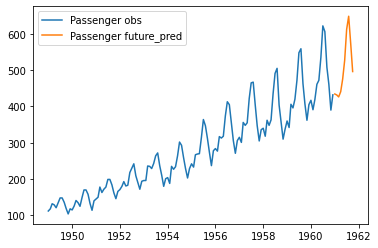

In [411]:
plt.plot(df.index, df['#Passengers'], label="Passenger obs")
plt.plot(predicted_case_df.index, predicted_case_df["Future Passenger"][:], label="Passenger future_pred")
plt.legend()
plt.show()